# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](MPS.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](cptp.png)

1. Trace over the first index of $R^{(j)}$
  
  $$
    R^{(j)}_{a_{1:D},a'_{1:D}}\rightarrow \sum_{a}R^{(j)}_{a a_{1:D-1},a a'_{1:D-1}}
  $$
  
  This reduces the number of indices of $R^{(j)}$ to $2(d-2)$, or $q^{2(d-2)}$ components.

2. Apply the unitaries $U_{d-1}$ and $\bar U_{d-1}$. This increases the rank of the resulting tensor back to $2(d-1)$.

3. Continue applying unitaries from the __middle out__ for $j=d-2,\ldots 2$.

4. Apply $U_1$ and $U^\dagger_1$, with the outer indices fixed.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc import (cptp_map, next_step, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, random_gates, random_state, inner_product)

## Einsum path optimization

In [3]:
q = 2
depth = 3
gates = random_gates(q, depth)
ρ = random_ρ(q, depth)
path = np.einsum_path('aACx,bBCy,ab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [4]:
print(path[0])

['einsum_path', (0, 1), (0, 1)]


In [5]:
print(path[1])

  Complete contraction:  aACx,bBCy,abcpsK->ABcpsKxy
         Naive scaling:  11
     Optimized scaling:  10
      Naive FLOP count:  6.144e+03
  Optimized FLOP count:  2.305e+03
   Theoretical speedup:  2.666
  Largest intermediate:  2.560e+02 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           bBCy,aACx->ABabxy                  abcpsK,ABabxy->ABcpsKxy
  10     ABabxy,abcpsK->ABcpsKxy                       ABcpsKxy->ABcpsKxy


In [6]:
path = np.einsum_path('aACx,bBDy,CDab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [7]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [8]:
print(path[1])

  Complete contraction:  aACx,bBDy,CDabsK->ABsKxy
         Naive scaling:  10
     Optimized scaling:  8
      Naive FLOP count:  3.072e+03
  Optimized FLOP count:  1.025e+03
   Theoretical speedup:  2.997
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   8         CDabsK,aACx->ADKbsx                      bBDy,ADKbsx->ABsKxy
   8         ADKbsx,bBDy->ABsKxy                           ABsKxy->ABsKxy


In [9]:
path = np.einsum_path('Cx,Dy,CD...->...xy', gates[-1][0, 0], gates[-1][0, 0].conj(), ρ, optimize=True)

In [10]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [11]:
print(path[1])

  Complete contraction:  Cx,Dy,CDpsKB->psKBxy
         Naive scaling:  8
     Optimized scaling:  7
      Naive FLOP count:  7.680e+02
  Optimized FLOP count:  5.130e+02
   Theoretical speedup:  1.497
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           CDpsKB,Cx->BDKpsx                        Dy,BDKpsx->psKBxy
   7           BDKpsx,Dy->psKBxy                           psKBxy->psKBxy


## Complexity

Don't forget that __depth__ is the number of gates, one more than the number of indices

In [12]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o cptp_map(random_ρ(q, d - 1), random_gates(q, d))
    timeit_results.append(res.average)

1.06 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.37 ms ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.01 ms ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.2 ms ± 64.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.26 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45.2 ms ± 791 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
249 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2 s ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

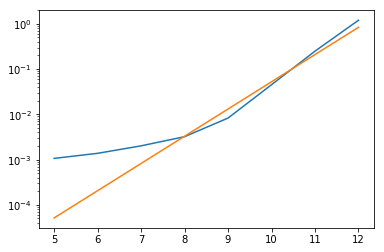

In [13]:
plt.semilogy(depths, timeit_results, depths, 0.00000005*4**depths)

## CPTP map simulation

In [14]:
q = 2
purities = []
depths = np.arange(5, 12)
for d in depths:
    
    print("depth: ", d)
    ρ = random_ρ(q, d - 1)
    purity_trace = np.array([])
    eigenvalues = np.array([])

    for step in range(1000):
        purity_trace = np.append(purity_trace, trace_square(ρ))
        eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
        ρ = cptp_map(ρ, random_gates(q, d))
    
    purities.append(-np.log(np.mean(purity_trace)))

depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
depth:  11


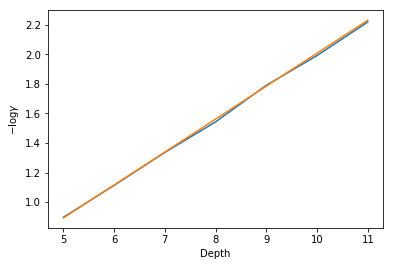

In [16]:
plt.plot(depths, purities)
plt.plot(depths, (depths - 1) * np.log(5/4))
plt.xlabel("Depth")
plt.ylabel("$-\log\gamma$");

Fits nicely with the predicted $(4/5)^t$ behaviour of the purity!

## Purity from CPTP map

In [5]:
np.mean(purity_trace)

(0.13320734449324811-1.8874435759237615e-18j)

In [6]:
-np.log(np.mean(purity_trace))

(2.015848383557739+1.416921554216127e-17j)

In [9]:
-np.log((4/5)**9)

2.0082919618278874

In [64]:
plt.plot(-np.log(np.real(purity_trace)))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

NameError: name 'purity_trace' is not defined

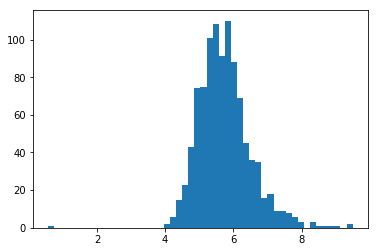

In [24]:
plt.hist(-np.log(np.real(purity_trace)), bins=50);

## Spectrum

In [63]:
plt.hist(np.log(eigenvalues), bins=200);

NameError: name 'eigenvalues' is not defined

Compare with fully random density matrix

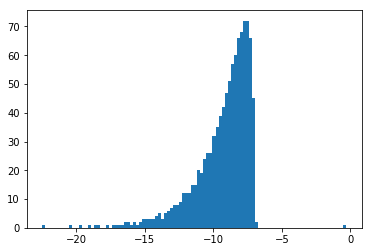

In [26]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$. It is important that the trajectories are sampled from the probabilites corresponding to the ancilla states followed.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

__Opportunity__ to parallelize as one just needs to gather the inner products across trajectories

In [19]:
import time

In [20]:
q = 2
purities_traj = []
variances = []
depths = np.arange(5, 19)
for d in depths:
    
    print("Depth: ", d)
    print(time.ctime())
    state1 = random_state(q, d - 1)
    state2 = state1
    purity_traj = np.array([])

    for step in range(1000):
        purity_traj = np.append(purity_traj, np.abs(inner_product(state1, state2))**2)
        gates = random_gates(q, d) 
        probs1, states1 = next_step(state1, gates)
        probs2, states2 = next_step(state2, gates)
        state1 = states1[np.random.choice(range(q**2), p=probs1)]
        state2 = states2[np.random.choice(range(q**2), p=probs2)]
    
    purities_traj.append(np.mean(purity_traj))
    variances.append(np.var(purity_traj))


Depth:  5
Fri Feb 15 16:20:25 2019
Depth:  6
Fri Feb 15 16:20:26 2019
Depth:  7
Fri Feb 15 16:20:27 2019
Depth:  8
Fri Feb 15 16:20:29 2019
Depth:  9
Fri Feb 15 16:20:30 2019
Depth:  10
Fri Feb 15 16:20:33 2019
Depth:  11
Fri Feb 15 16:20:37 2019
Depth:  12
Fri Feb 15 16:20:44 2019
Depth:  13
Fri Feb 15 16:21:00 2019
Depth:  14
Fri Feb 15 16:21:33 2019
Depth:  15
Fri Feb 15 16:22:42 2019
Depth:  16
Fri Feb 15 16:25:08 2019
Depth:  17
Fri Feb 15 16:30:16 2019
Depth:  18
Fri Feb 15 16:41:30 2019


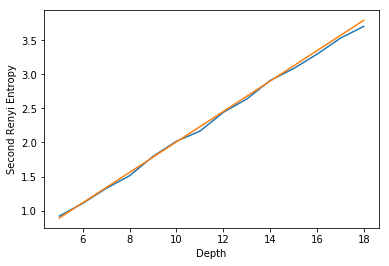

In [21]:
plt.plot(depths, -np.log(purities_traj))
plt.plot(depths, (depths - 1) * np.log(5/4))
plt.xlabel("Depth")
plt.ylabel("Second Renyi Entropy");

In [48]:
depth = 20
state1 = random_state(q, depth - 1)
state2 = random_state(q, depth - 1)
purity_traj = np.array([])

for step in range(100):
    purity_traj = np.append(purity_traj, np.abs(inner_product(state1, state2))**2)
    gates = random_gates(q, depth) 
    probs1, states1 = next_step(state1, gates)
    probs2, states2 = next_step(state2, gates)
    state1 = states1[np.random.choice(range(q**2), p=probs1)]
    state2 = states2[np.random.choice(range(q**2), p=probs2)]

    print("step: ", step)

step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
step:  21
step:  22
step:  23
step:  24
step:  25
step:  26
step:  27
step:  28
step:  29
step:  30
step:  31
step:  32
step:  33
step:  34
step:  35
step:  36
step:  37
step:  38
step:  39
step:  40
step:  41
step:  42
step:  43
step:  44
step:  45
step:  46
step:  47
step:  48
step:  49
step:  50
step:  51
step:  52
step:  53
step:  54
step:  55
step:  56
step:  57
step:  58
step:  59
step:  60
step:  61
step:  62
step:  63
step:  64
step:  65
step:  66
step:  67
step:  68
step:  69
step:  70
step:  71
step:  72
step:  73
step:  74
step:  75
step:  76
step:  77
step:  78
step:  79
step:  80
step:  81
step:  82
step:  83
step:  84
step:  85
step:  86
step:  87
step:  88
step:  89
step:  90
step:  91
step:  92
step:  93
step:  94
step:  95
step:  96
step:  97
step:  98
step:  99


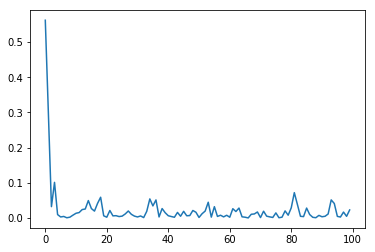

In [49]:
plt.plot(purity_traj)


In [55]:
np.mean(purity_traj[10:])

0.015277429252694276

In [51]:
(4/5)**19

0.014411518807585602